# Skater
**Authors: [Xin Feng](https://github.com/xf37)** 


Skater is a constrained spatial regionalization algorithm based on spanning tree pruning. The number of edges is prespecified to be cut in a continuous tree to group spatial units into contiguous regions.  

The first step of Skater is to create a connectivity graph that captures the neighbourhood relationship between the spatial objects. The cost of each edge in the graph is inversely proportional to the similarity between the regions it joins. The neighbourhood is structured by a minimum spanning tree (MST), which is a connected tree with no circuits. The next step is to partition the MST by successive removal of edges that link dissimilar regions. The final result is the division of the spatial objects into connected regions that have maximum internal homogeneity. More details can be found in ([AssunCao et al., 2006](https://www.tandfonline.com/doi/full/10.1080/13658810600665111?casa_token=ovYjEkDDjbAAAAAA%3AjX8FMJWkrJDbSy8nmGiCOUFV6Fl-5KAhDibrQ89qqEpM4HvJ5wyNsrn7_x5qOwLmauKIh-RUdfZm)).

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-17T21:50:45.104201-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
from libpysal.examples import load_example
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import pairwise as skm
import spopt
from spopt.region.skater import Skater

plt.rcParams["figure.figsize"] = [12, 8]

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

spopt     : 0.4.1+200.g336f235.dirty
json      : 2.0.9
numpy     : 1.23.3
libpysal  : 4.6.2
geopandas : 0.11.1
sklearn   : 1.1.2
matplotlib: 3.6.1



## Airbnb Spots Clustering in Chicago

To illustrate `Skater` we utilize data on Airbnb spots in Chicago, which can be downloaded from [libpysal.examples](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html).

We can first explore the data by plotting the number of Airbnb spots in each community in the sample, using a quintile classification:

In [3]:
load_example("AirBnB")

Example not available: AirBnB
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


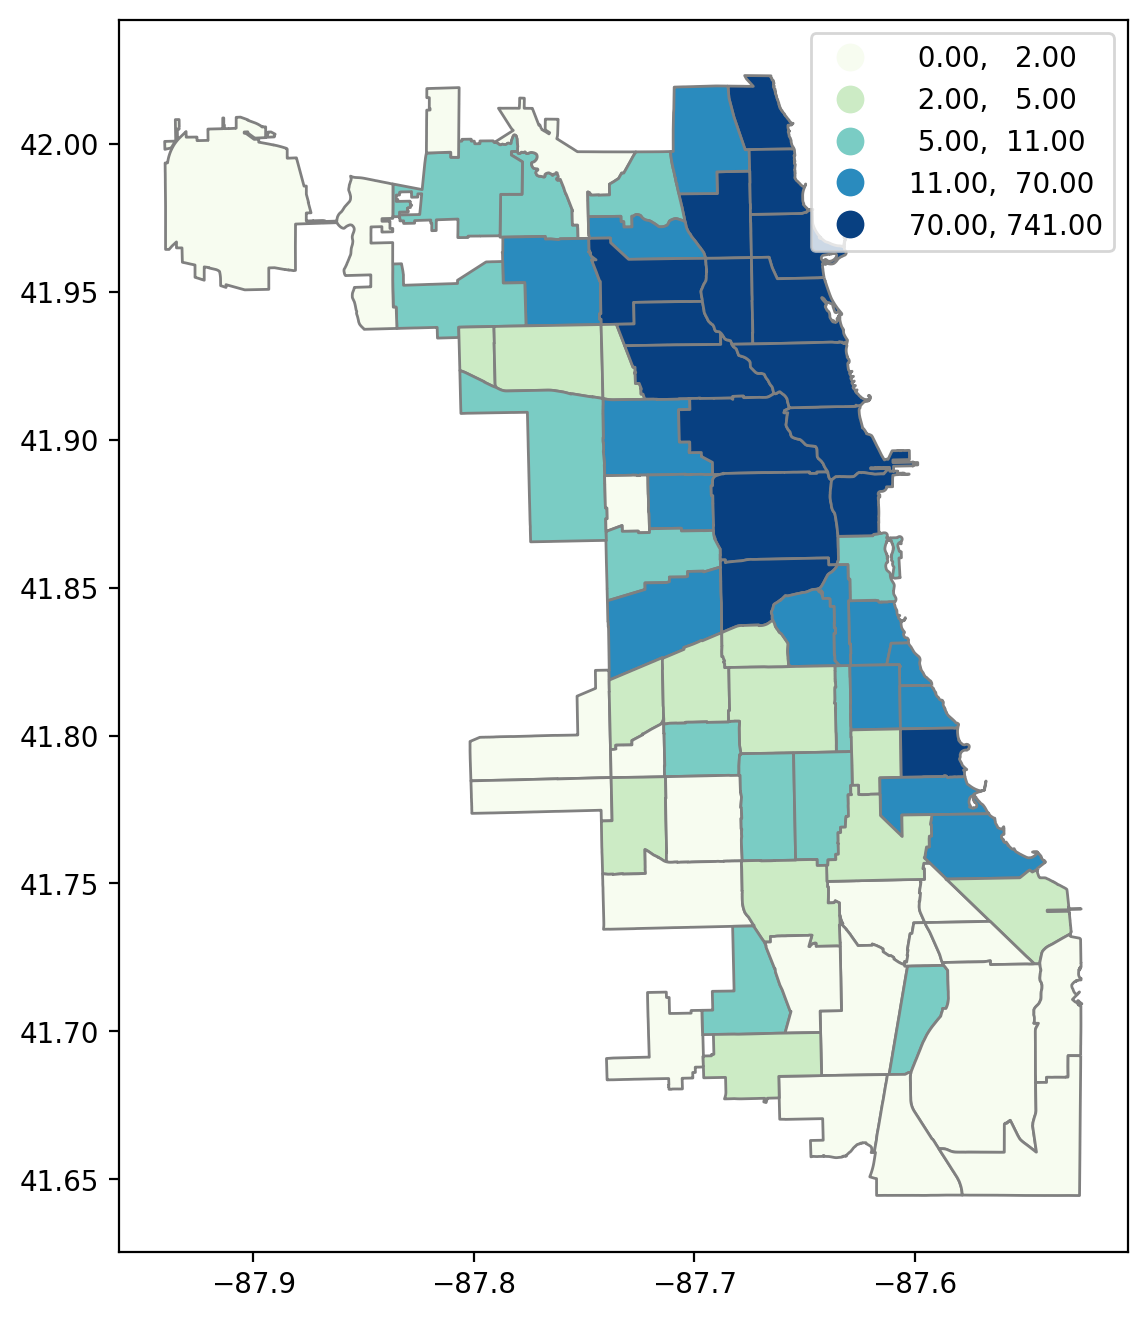

In [4]:
pth = libpysal.examples.get_path("airbnb_Chicago 2015.shp")
chicago = geopandas.read_file(pth)
chicago.plot(
    column="num_spots", scheme="Quantiles", cmap="GnBu", edgecolor="grey", legend=True
);

## Regionalization

With Skater, we can cluster these 77 communities into 5 regions such that each region consists of at least 5 communities. The homogeneity of the number of Airbnb spots per county within the regions is maximized.

We first define the variable that will be used to measure regional homogeneity, which is the number of Airbnb spots in this case.

In [5]:
attrs_name = ["num_spots"]

Next, we specify a number of other parameters that will serve as input to the `skater` model, including the spatial weight (to describe the relationship between the spatial objects), the number of regions, the least spatial objects in each region, etc.

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) describes the spatial connectivity of the spatial objects:

In [6]:
w = libpysal.weights.Queen.from_dataframe(chicago)

The number of contiguous regions that we would like to group spatial units into:

In [7]:
n_clusters = 5

The minimum number of spatial objects in each region：

In [8]:
floor = 5

 `trace` is a bool denoting whether to store intermediate labelings as the tree gets pruned

In [9]:
trace = False

We can set the a string to `islands` to describe what to do with islands. 
If "ignore", will discover `n_clusters` regions, treating islands as their own regions.
If "increase", will discover `n_clusters` regions, treating islands as separate from n_clusters. 

In [10]:
islands = "increase"

We can also specify some key words as imput to the spanning forest algorithm, including:

dissimilarity : a callable distance metric

affinity : an callable affinity metric between 0,1. 
           Will be inverted to provide a dissimilarity metric.
           
reduction: the reduction applied over all clusters to provide the map score.

center:    way to compute the center of each region in attribute space

In [11]:
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
)

The model can then be instantiated and solved:

In [12]:
model = Skater(
    chicago, w, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds
)
model.solve()

In [13]:
chicago["skater_new"] = model.labels_
chicago["number"] = 1

In [14]:
chicago[["skater_new", "number"]].groupby(by="skater_new").count()

,number
skater_new,
0,5
1,54
2,7
3,5
4,6


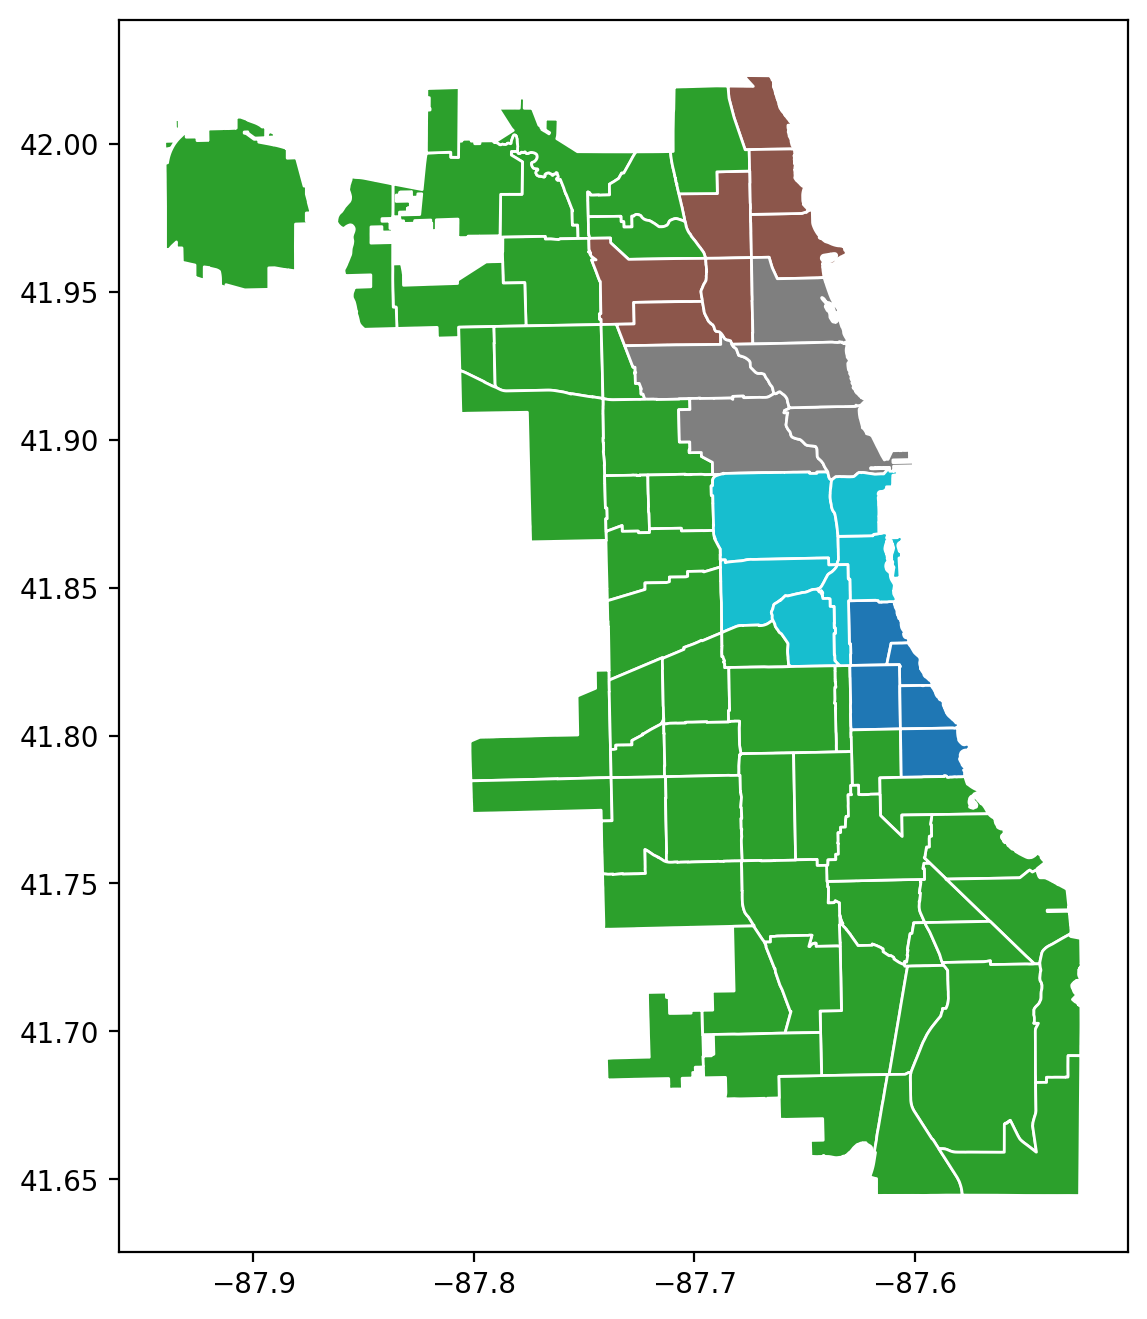

In [15]:
chicago.plot(column="skater_new", categorical=True, edgecolor="w");

The model solution results in five regions, two of which have five communities, one with six, one with seven, and one with fifty-four communities. 